# FBA/$\epsilon$ water model

References :
* Original paper : https://www.if.ufrgs.br/~barbosa/Publications/Physics/fuentes-azcatl-JML-2020.pdf
* Analytical expressions for the forces : https://manual.gromacs.org/documentation/current/reference-manual/functions/functions.html
* Simulation reference : https://www.nist.gov/programs-projects/nist-standard-reference-simulation-website

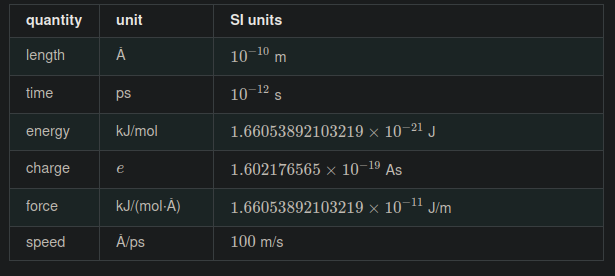

In [111]:
from dataclasses import dataclass
import numpy as np
from nptyping import NDArray, Shape, Float, UInt
from pathlib import Path
import re
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import itertools

In [448]:
ATOM_TYPES: dict[str, UInt] = { 'H': 1, 'O': 16 }
ATOM_MASSES: dict[str, dict[UInt, float]] = {  # atomic masses, g/mol
	'FBAeps': { 'H': 1.0078, 'O': 15.9994 }
}
# https://github.com/MDAnalysis/mdanalysis/blob/develop/package/MDAnalysis/units.py
K_B = 8.314462159e-3  # boltzmann constant, kJ/(mol.K)
N_A = 6.02214076e23   # avogadro number [1/mol]
EPS0 = 5.526350e-3  # [e²/((kJ/mol).A)]
ELEMENTARY_CHARGE = 1.602176565e-19  # [As]

# System

@dataclass
class System:
	x: NDArray[Shape['N,3'], Float]           # positions [A]
	v: NDArray[Shape['N,3'], Float]           # velocities [A/ps]
	m: NDArray[Shape['N,3'], Float]           # masses [atomic units]
	lattice: NDArray[Shape['3'], Float]       # dimensions of the periodic cubic lattice [A]
	bonds: NDArray[Shape['B,2'], UInt]        # bond indices
	angles: NDArray[Shape['A,3'], UInt]       # angle indices
	atomtypes: NDArray[Shape['N'], UInt]      # atom types

	def __post_init__(self):
		assert len(self.x) == len(self.v) == len(self.m) == len(self.atomtypes)
		self.N = len(self.x)
		# TODO : precompute all pair indices
		# TODO : precompute all OO indices

	def init(self, T: float, random_seed: int = 42):
		"""Initialize the system

		Samples momenta from the Maxwell-Boltzmann distribution (see https://manual.gromacs.org/documentation/current/reference-manual/algorithms/molecular-dynamics.html#coordinates-and-velocities)

		Parameters
		----------
		T : float
			temperature in Kelvin
		random_seed : int, optional
			random seed, by default 42
		"""
		self.v = np.random.default_rng(random_seed).normal(0, np.sqrt(T*K_B/self.m[:, None]), (self.N, 3))

	def temperature(self) -> float:
		"""temperature of the system in K"""
		return 2*self.kinetic_energy() / (3*self.N*K_B)

	def kinetic_energy(self) -> float:
		"""kinetic energy in kJ/mol"""
		return np.sum(np.sum(self.v**2, axis=1)*self.m)/2

	def volume(self) -> float:
		"""volume of the simulation box in A³"""
		return np.prod(self.lattice)

	def density(self) -> float:
		"""density in 1/A³"""
		return self.m.sum() / self.volume()

	def pressure(self) -> float:
		"""pressure in kJ/(mol.A³)"""
		# TODO : the virial must be computed from the forces
		# return (2*self.kinetic_energy() + virial)/(3*self.volume())

	@staticmethod
	def load_NIST(filepath: Path, model: str = 'FBAeps') -> 'System':
		with open(filepath, 'r') as file:
			lattice = np.array([float(l) for l in re.split(r'\s+', file.readline().strip()) ])
			A = int(file.readline().strip())  # A : number of molecules (1 angle per molecule)
			B = 2*A  # B : number of bonds (2 bonds per molecule)
			N = 3*A  # N : number of atoms (3 atoms per molecule)

			x = np.zeros((N, 3), dtype=Float)
			v = np.zeros((N, 3), dtype=Float)
			m = np.zeros(N, dtype=Float)
			atomtypes = np.zeros(N, dtype=UInt)
			bonds = np.zeros((B, 2), dtype=UInt)
			angles = np.zeros((A,  3), dtype=UInt)
			i = 0
			b = 0
			for a in range(A):
				bonds[b, :]   = i, i+1
				bonds[b+1, :] = i, i+2
				angles[a, :]  = i+1, i, i+2
				for _ in range(3):
					line = re.split(r'\s+', file.readline().strip())
					x[i, :] = [ float(x_) for x_ in line[1:4] ]
					atomtypes[i] = ATOM_TYPES[line[4]]
					m[i] = ATOM_MASSES[model][line[4]]
					assert i == int(line[0])-1
					i += 1
				b += 2

			return System(x=x, v=v, m=m, lattice=lattice, bonds=bonds, angles=angles, atomtypes=atomtypes)

	def init_maxwellboltzmann(self):
		# TODO : sample velocities from maxwell-boltzmann
		raise NotImplementedError()

In [449]:
# plotting functions

def d12_periodic(x1, x2, lattice):
	"""Compute the distance vector 1->2 between ``x1`` and ``x2`` in the cubic lattice"""
	d = np.array((x2 - x1, x2 - x1 + lattice, x2 - x1 - lattice))
	return d[np.argmin(np.abs(d), axis=0), [0,1,2]]

def plot_sys(sys: System):
	fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
	ax.set_proj_type('ortho')
	for i, j in sys.bonds:
		x1, x2 = sys.x[i], sys.x[j]
		d12 = d12_periodic(x1, x2, sys.lattice)
		ax.plot(*np.array((x1, x1+d12)).T, color='k', alpha=0.4)
	ax.scatter(*sys.x[sys.atomtypes == ATOM_TYPES['H']].T, color='blue', linewidth=0, alpha=1)
	ax.scatter(*sys.x[sys.atomtypes == ATOM_TYPES['O']].T, color='red', linewidth=0, alpha=1)
	ax.set_xlim((-sys.lattice[0]/2, +sys.lattice[0]/2))
	ax.set_ylim((-sys.lattice[1]/2, +sys.lattice[1]/2))
	ax.set_zlim((-sys.lattice[2]/2, +sys.lattice[2]/2))
	ax.set_title(f'System with $M={sys.N//3}$ water molecules')
	ax.set_xlabel('x [A]')
	ax.set_ylabel('y [A]')
	ax.set_zlabel('z [A]')
	return fig, ax

def plot_rotating(sys: System, frames: int = 100, interval: int = 100):
	fig, ax = plot_sys(sys)
	azims = np.linspace(0, 360, frames)

	def animate(i):
		ax.view_init(azim=azims[i])
		return fig,

	ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
	plt.close(fig)
	return HTML(ani.to_html5_video())

In [ ]:
sys = System.load_NIST('data/nist_SPC_E_water_data/spce_sample_config_periodic1.txt')
# plot_rotating(sys, frames=360, interval=30)

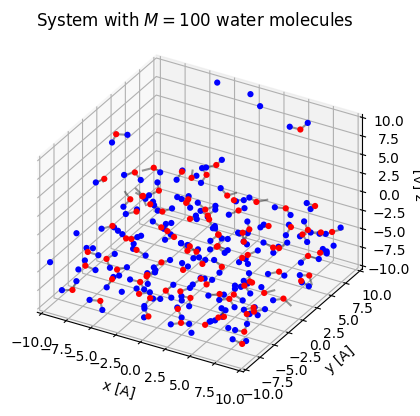

In [450]:
sys = System.load_NIST('data/nist_SPC_E_water_data/spce_sample_config_periodic1.txt')
sys.init(T=25+273.15)
plot_sys(sys);

In [581]:
# Force fields

@dataclass(slots=True)
class ForceField:
	class Result:
		def __init__(self, N: int):
			self.forces: NDArray[Shape['N,3'], Float] = np.zeros((N, 3), dtype=Float)  # [kJ/(mol.A)]
			self.potential_total: float = 0.0  # [kJ/mol]
			self.potential_LJ: float = 0.0  # [kJ/mol]
			self.potential_elec: float = 0.0  # [kJ/mol]
			self.potential_bond: float = 0.0  # [kJ/mol]
			self.potential_bend: float = 0.0  # [kJ/mol]

	def forces(self, sys: System) -> 'ForceField.Result':
		raise NotImplementedError()

@dataclass(slots=True)
class FBAeps(ForceField):
	eps_OO: float = 0.792324   # O-O Lennard-Jones energy scale [kJ/mol]
	sigma_OO: float = 3.1776   # O-O Lennard-Jones repulsive diameter pair [A]
	q_O: float = -0.8450       # O site charge [e]
	q_H: float = 0.4225        # H site charge [e]
	r_OH: float = 1.027        # O-H bond resting distance [A]
	k_OH: float = 3000         # O-H bond spring coefficient [kJ/(mol.A²)]
	theta_HOH: float = np.deg2rad(114.70)  # H-O-H resting angle [rad]
	k_HOH: float = 383         # H-O-H angle spring coefficient [kJ/(mol.rad²)]

	def forces(self, sys: System) -> ForceField.Result:
		res = ForceField.Result(N=len(sys.x))
		self.forces_LJ(sys, res)
		self.forces_elec(sys, res)
		self.forces_bond(sys, res)
		self.forces_bend(sys, res)
		return res

	def forces_LJ(self, sys: System, res: ForceField.Result | None = None) -> ForceField.Result:
		if res is None:
			res = ForceField.Result(N=len(sys.x))

		for a, b in itertools.product(range(sys.N), range(sys.N)):
			# TODO : precompute these indices
			if a == b: continue
			if sys.atomtypes[a] != ATOM_TYPES['O'] or sys.atomtypes[b] != ATOM_TYPES['O']: continue
			
			d = d12_periodic(sys.x[a], sys.x[b], sys.lattice)
			r = np.linalg.norm(d)
			f = -4*self.eps_OO * (12*self.sigma_OO**12/r**13 - 6*self.sigma_OO**6/r**7) * d/r
			res.forces[a] += f
			res.forces[b] += -f
			res.potential_LJ += 4*self.eps_OO * (self.sigma_OO**12/r**12 - self.sigma_OO**6/r**6)
		
		res.potential_total += res.potential_LJ
		return res

	def forces_elec(self, sys: System, res: ForceField.Result | None = None) -> ForceField.Result:
		if res is None:
			res = ForceField.Result(N=len(sys.x))

		for a, b in itertools.product(range(sys.N), range(sys.N)):
			# TODO : precompute these indices
			if a == b: continue

			# TODO : precompute this
			q_a = self.q_O if sys.atomtypes[a] == ATOM_TYPES['O'] else self.q_H
			q_b = self.q_O if sys.atomtypes[b] == ATOM_TYPES['O'] else self.q_H

			d = d12_periodic(sys.x[a], sys.x[b], sys.lattice)
			r = np.linalg.norm(d)
			f = -1/(4*np.pi*EPS0) * q_a*q_b/r**2 * d/r

			res.forces[a] += f
			res.forces[b] += -f
			res.potential_elec += 1/(4*np.pi*EPS0) * q_a*q_b/r

		res.potential_total += res.potential_elec
		return res

	def forces_bond(self, sys: System, res: ForceField.Result | None = None) -> ForceField.Result:
		if res is None:
			res = ForceField.Result(N=len(sys.x))

		for a, b in sys.bonds:
			d = d12_periodic(sys.x[a], sys.x[b], sys.lattice)
			r = np.linalg.norm(d)
			f = self.k_OH * (r - self.r_OH) * d/r

			res.forces[a] += f
			res.forces[b] += -f
			res.potential_bond += self.k_OH/2 * (r - self.r_OH)**2

		res.potential_total += res.potential_bond
		return res

	def forces_bend(self, sys: System, res: ForceField.Result | None = None) -> ForceField.Result:
		# https://math.stackexchange.com/questions/1165532/gradient-of-an-angle-in-terms-of-the-vertices
		
		if res is None:
			res = ForceField.Result(N=len(sys.x))

		for a, b, c in sys.angles:
			dOH1 = d12_periodic(sys.x[b], sys.x[a], sys.lattice)
			dOH2 = d12_periodic(sys.x[b], sys.x[c], sys.lattice)
			rOH1 = np.linalg.norm(dOH1)
			rOH2 = np.linalg.norm(dOH2)
			theta = np.arccos(np.dot(dOH1, dOH2) / (rOH1 * rOH2))
			
			num1 = np.cross(dOH1, np.cross(dOH1, dOH2))
			dtheta1 = num1 / np.linalg.norm(num1) / rOH1
			fH1 = -self.k_HOH * (theta - self.theta_HOH) * dtheta1
			res.forces[a] += fH1
			
			num2 = np.cross(dOH2, np.cross(dOH2, dOH1))
			dtheta2 = num2 / np.linalg.norm(num2) / rOH2
			fH2 = -self.k_HOH * (theta - self.theta_HOH) * dtheta2
			res.forces[c] += fH2

			res.forces[b] += -(fH1 + fH2)

			res.potential_bend += self.k_HOH/2 * (theta - self.theta_HOH)**2

		res.potential_total += res.potential_bend
		return res

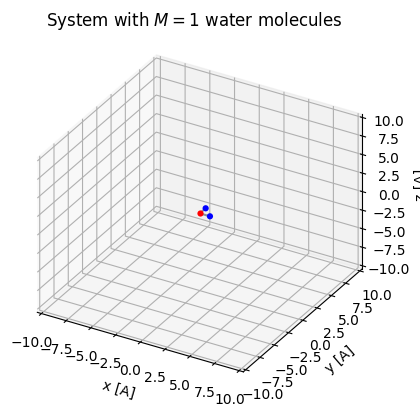

In [582]:
sys = System.load_NIST('data/debug5.txt')
plot_sys(sys);
plt.show()

In [583]:
ff = FBAeps()
res_bond = ff.forces_bond(sys)
print(res_bond.forces)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [584]:
ff = FBAeps()
res_bond = ff.forces_bend(sys)
print(res_bond.forces)

[[ 160.76912616  160.76912616    0.        ]
 [   0.         -160.76912616    0.        ]
 [-160.76912616    0.            0.        ]]


In [585]:
ff = FBAeps()
res_bond = ff.forces_elec(sys)
print(res_bond.forces)

[[ 9.74819662  9.74819662  0.        ]
 [-8.02494263 -1.72325398  0.        ]
 [-1.72325398 -8.02494263  0.        ]]


In [586]:
ff = FBAeps()
res_bond = ff.forces_LJ(sys)
print(res_bond.forces)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [587]:
ff = FBAeps()
res_all = ff.forces(sys)
print(res_all.forces)

[[ 170.51732278  170.51732278    0.        ]
 [  -8.02494263 -162.49238014    0.        ]
 [-162.49238014   -8.02494263    0.        ]]


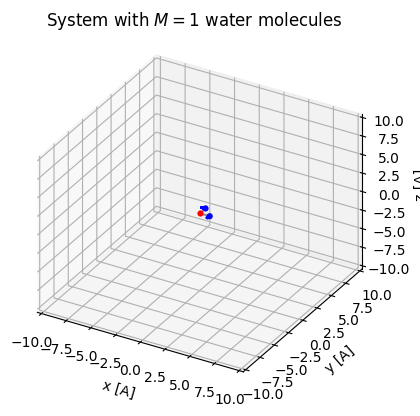

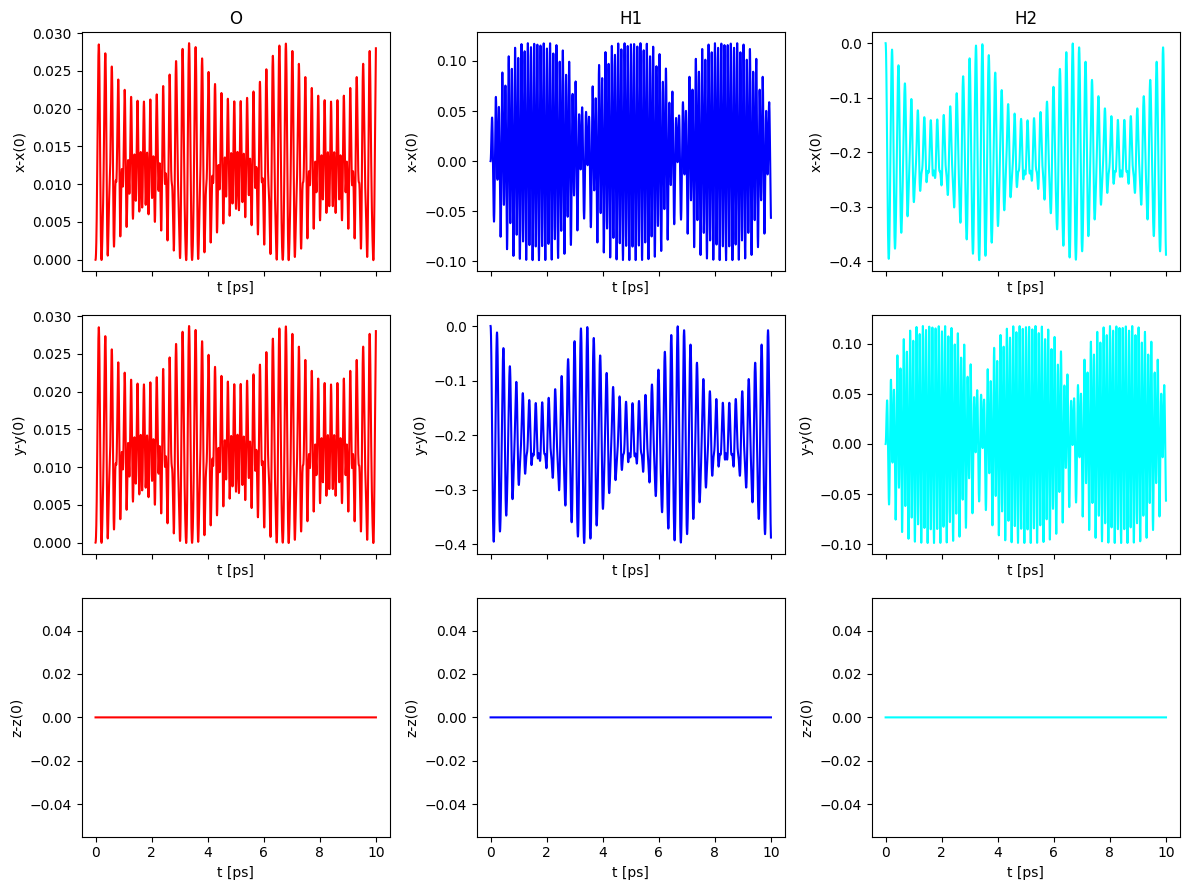

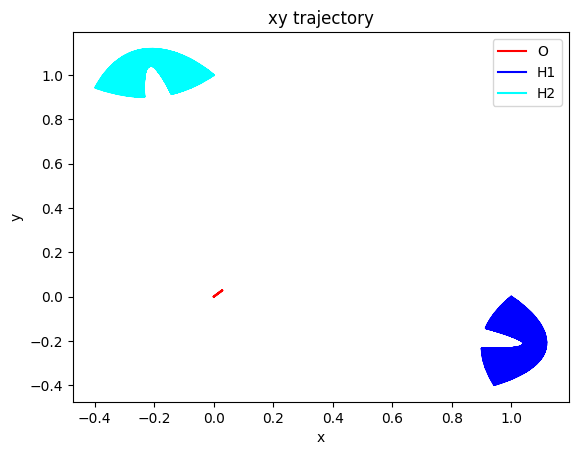

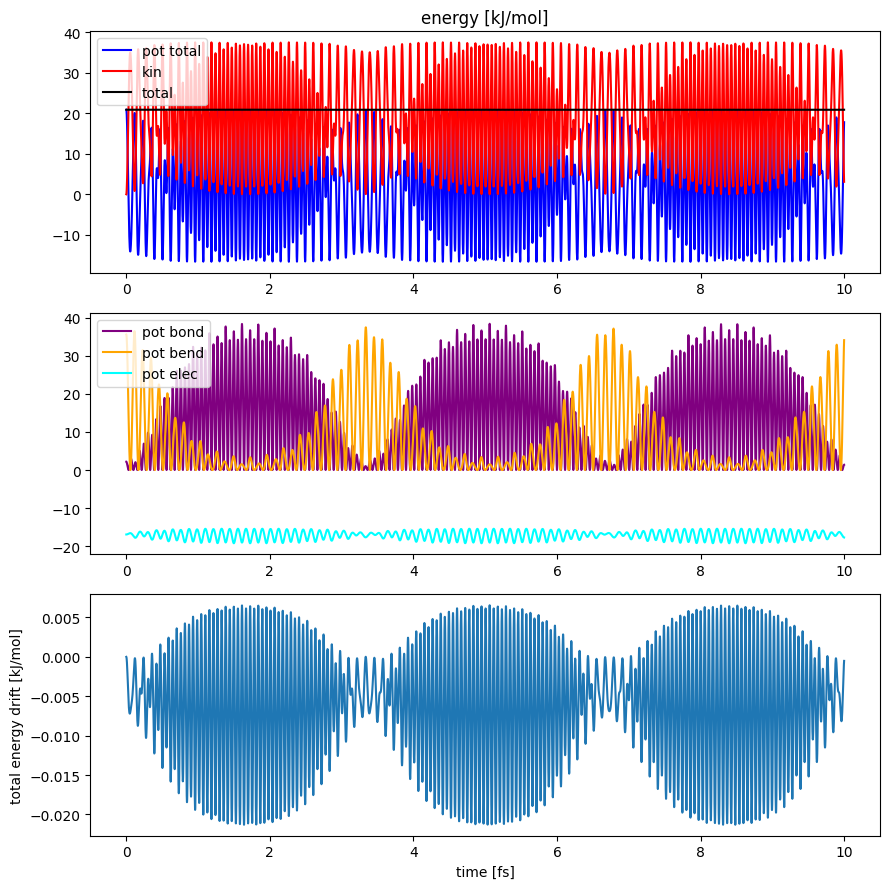

In [594]:
# Integrator

@dataclass(slots=True)
class Integrator:
	dt: float  # time step [ps]
	t: float = 0

	def init(self):
		self.t = 0

	def step(sys: System, ff: ForceField) -> None:
		raise NotImplementedError()
		# TODO : after stepping, remember to roll the particles back to the original box

@dataclass(slots=True)
class LeapFrog(Integrator):
	def step(self, sys: System, ff: ForceField):
		# print('t-dt/2')
		res = ff.forces(sys)
		# print(res.forces)
		sys.v += res.forces/sys.m[:, None] * self.dt/2
		sys.x += sys.v * self.dt
		# print('t+dt/2')
		res = ff.forces(sys)
		sys.v += res.forces/sys.m[:, None] * self.dt/2
		self.t += self.dt


sys = System.load_NIST('data/debug1.txt')
# sys.init(T=298.15)
fig, ax = plot_sys(sys)
ff = FBAeps()
integ = LeapFrog(dt=1e-3)  # 1 fs
integ.init()

xs = []
potential_total = []
kinetic = []
potential_bend = []
potential_bond = []
potential_elec = []
potential_total.append(ff.forces(sys).potential_total)
potential_bend.append(ff.forces(sys).potential_bend)
potential_bond.append(ff.forces(sys).potential_bond)
potential_elec.append(ff.forces(sys).potential_elec)
kinetic.append(sys.kinetic_energy())
xs.append(sys.x.copy())
t = [0]
for _ in range(10000):
	integ.step(sys, ff)
	f = ff.forces(sys)
	potential_bend.append(f.potential_bend)
	potential_bond.append(f.potential_bond)
	potential_elec.append(f.potential_elec)
	potential_total.append(f.potential_total)
	kinetic.append(sys.kinetic_energy())
	xs.append(sys.x.copy())
	t.append(integ.t)
xs = np.stack(xs, axis=-1)
potential_total = np.array(potential_total)
kinetic = np.array(kinetic)
total = potential_total + kinetic
t = np.array(t)

ax.plot(xs[0, 0, :], xs[0, 1, :], xs[0, 2, :], color='red')
ax.plot(xs[1, 0, :], xs[1, 1, :], xs[1, 2, :], color='blue')
ax.plot(xs[2, 0, :], xs[2, 1, :], xs[2, 2, :], color='blue')
plt.show()

fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, layout='tight', figsize=(12, 9))
for i, color, name in zip(range(3), ['red', 'blue', 'cyan'], ['O', 'H1', 'H2']):
	axes[0, i].set_title(name)
	for mu, coordname in zip(range(3), ['x', 'y', 'z']):
		axes[mu, i].plot(t, xs[i, mu, :] - xs[i, mu, 0], color=color)
		axes[mu, i].set_xlabel('t [ps]')
		axes[mu, i].set_ylabel(f'{coordname}-{coordname}(0)')
plt.show()

fig, ax = plt.subplots()
ax.plot(xs[0, 0, :], xs[0, 1, :], label='O', color='red')
ax.plot(xs[1, 0, :], xs[1, 1, :], label='H1', color='blue')
ax.plot(xs[2, 0, :], xs[2, 1, :], label='H2', color='cyan')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('xy trajectory')
plt.show()

fig, axes = plt.subplots(nrows=3, layout='tight', figsize=(9, 9))
axes[0].plot(t, potential_total, color='blue', label='pot total')
axes[0].plot(t, kinetic, color='red', label='kin')
axes[0].plot(t, total, color='black', label='total')
# ax.twinx().plot(t, potential + kinetic)
# axes[0].set_xlabel('time [fs]')
axes[0].set_title('energy [kJ/mol]')
axes[0].legend()
axes[1].plot(t, potential_bond, color='purple', label='pot bond')
axes[1].plot(t, potential_bend, color='orange', label='pot bend')
axes[1].plot(t, potential_elec, color='cyan', label='pot elec')
axes[1].legend()
axes[2].plot(t, total-total[0])
axes[2].set_xlabel('time [fs]')
axes[2].set_ylabel('total energy drift [kJ/mol]')
plt.show()

NOTE : leapfrog should conserve energy, but here is does not. this is because the harmonic bending force does NOT derive from a potential !!

TODO : study transfer of vibrational nodes between bond and bend

In [568]:
# Simulation parameters

@dataclass(slots=True)
class SimParams:
	integrator: Integrator
	ff: ForceField
	T: float  # temperature in Kelvin